<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/2%20Aprendizaje%20profundo%20(I)/Sesion%204/Inputs%20heterogeneos/house_opcion5_macrofoto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Predicción del valor de venta de una casa**</h1></font>

<font color="#6E6E6E"><h1 align="left">Opción 5: Modelo heterogéneo que usa variables numéricas y "macrofoto"</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>


In [ ]:
COLAB = True

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

%matplotlib inline

Adaptado de:

  https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

Que utiliza el dataset de:

https://arxiv.org/pdf/1609.08399.pdf

In [ ]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1nZ4bq0TsQn2x3bA-jvEvZylAT-c8bpQN',
                                        dest_path='./Houses-dataset.zip', unzip=True)

Unzipping...Done.


In [ ]:
!ls -la Houses-dataset

total 92
drwxr-xr-x 3 root root  4096 Nov 10 17:50 .
drwxr-xr-x 1 root root  4096 Nov 10 17:50 ..
-rw-r--r-- 1 root root 12029 Nov 10 17:50 HousesInfo.txt
drwxr-xr-x 2 root root 69632 Nov 10 17:50 photos


In [ ]:
!ls Houses-dataset/photos/165*

Houses-dataset/photos/165_bathroom.jpg	Houses-dataset/photos/165_frontal.jpg
Houses-dataset/photos/165_bedroom.jpg	Houses-dataset/photos/165_kitchen.jpg


In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
import glob
import cv2

def load_house_attributes(inputPath):
    # initialize the list of column names in the CSV file and then
    # load it using Pandas
    cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
    df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
    # determine (1) the unique zip codes and (2) the number of data
    # points with each zip code
    zipcodes = df["zipcode"].value_counts().keys().tolist()
    counts = df["zipcode"].value_counts().tolist()
    # loop over each of the unique zip codes and their corresponding
    # count
    for (zipcode, count) in zip(zipcodes, counts):
      # the zip code counts for our housing dataset is *extremely*
      # unbalanced (some only having 1 or 2 houses per zip code)
      # so let's sanitize our data by removing any houses with less
      # than 25 houses per zip code
      if count < 25:
          idxs = df[df["zipcode"] == zipcode].index
          df.drop(idxs, inplace=True)
    # return the data frame
    return df

In [ ]:
def process_house_attributes(df, train, test):
    # initialize the column names of the continuous data
    continuous = ["bedrooms", "bathrooms", "area"]
    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])
    # one-hot encode the zip code categorical data (by definition of
    # one-hot encoding, all output features are now in the range [0, 1])
    zipBinarizer = LabelBinarizer().fit(df["zipcode"])
    trainCategorical = zipBinarizer.transform(train["zipcode"])
    testCategorical = zipBinarizer.transform(test["zipcode"])
    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])
    # return the concatenated training and testing data
    return (trainX, testX)

In [ ]:
def load_house_images(df, inputPath):
    # initialize our images array (i.e., the house images themselves)
    images = []
    # loop over the indexes of the houses
    N = 3
    for i in df.index.values:
        # find the four images for the house and sort the file paths,
        # ensuring the four are always in the *same order*
        basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
        housePaths = sorted(list(glob.glob(basePath)))
    
        # initialize our list of input images along with the output image
        # after *combining* the four input images
        inputImages = []
        outputImage = np.zeros((N*64, N*64, 3), dtype="uint8")
        # loop over the input house paths
        for housePath in housePaths:
            # load the input image, resize it to be 32 32, and then
            # update the list of input images
            image = cv2.imread(housePath)
            image = cv2.resize(image, (N*32, N*32))
            image = image[:,:,[2,1,0]]
            inputImages.append(image)
        # tile the four input images in the output image such the first
        # image goes in the top-right corner, the second image in the
        # top-left corner, the third image in the bottom-right corner,
        # and the final image in the bottom-left corner
        outputImage[0:N*32,    0:N*32] = inputImages[0]
        outputImage[0:N*32,    N*32:N*64] = inputImages[1]
        outputImage[N*32:N*64, N*32:N*64] = inputImages[2]
        outputImage[N*32:N*64, 0:N*32] = inputImages[3]
        # add the tiled image to our set of images the network will be
        # trained on
        images.append(outputImage)
    # return our set of images
    return np.array(images)

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Input

def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    # return our model
    return model

In [ ]:
def create_cnn(inputShape, filters=(16, 32, 64, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same", activation="relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4, activation="relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model

In [ ]:
# import the necessary packages
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
import locale

In [ ]:
!ls Houses-dataset

HousesInfo.txt	photos


In [ ]:
# construct the path to the input .txt file that contains information
# on each house in the dataset and then load the dataset
print("[INFO] loading house attributes...")
inputPath = "./Houses-dataset/HousesInfo.txt"
df = load_house_attributes(inputPath)
# load the house images and then scale the pixel intensities to the
# range [0, 1]
print("[INFO] loading house images...")
images = load_house_images(df, "./Houses-dataset/photos")
images = images / 255.0

[INFO] loading house attributes...
[INFO] loading house images...


In [ ]:
images.shape

(362, 192, 192, 3)

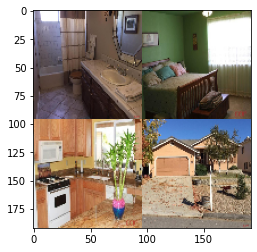

In [ ]:
plt.imshow(images[1]);

In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
print("[INFO] processing data...")
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice
# process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together
(trainAttrX, testAttrX) = process_house_attributes(df, trainAttrX, testAttrX)

[INFO] processing data...


In [ ]:
trainAttrX.shape

(271, 10)

In [ ]:
df.shape

(362, 5)

In [ ]:
images[0].shape

(192, 192, 3)

In [ ]:
len(images)

362

In [ ]:
# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(images[0].shape, regress=False)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [ ]:
trainAttrX.shape

(271, 10)

In [ ]:
# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

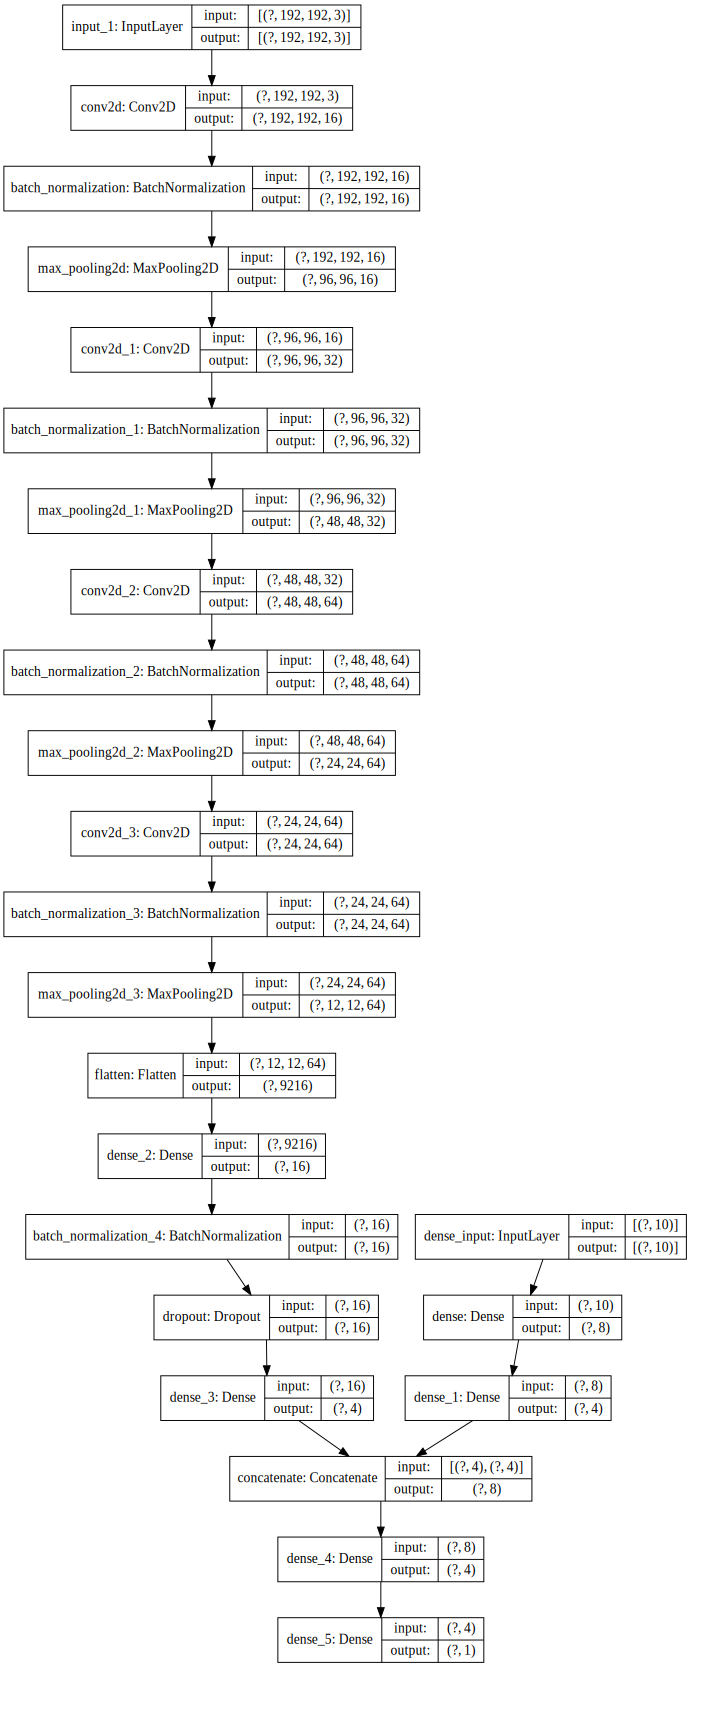

In [ ]:
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

def show_model(model):
    if COLAB:
        display(SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

show_model(model)

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_loss, val_loss):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_loss)), 100*np.array(tr_loss))
    plt.plot(1+np.arange(len(val_loss)), 100*np.array(val_loss))
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
trainAttrX.shape, trainY.shape

((271, 10), (271,))

In [ ]:
testAttrX.shape, testY.shape

((91, 10), (91,))

In [ ]:
acum_tr_loss  = []
acum_val_loss = []

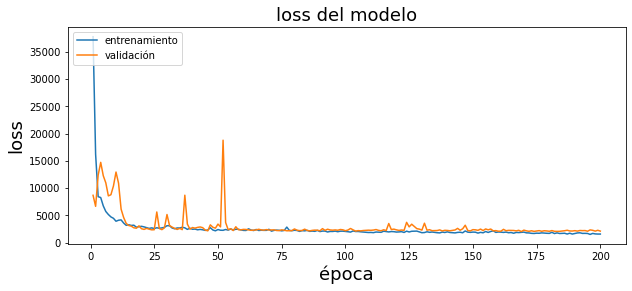

In [ ]:
# training:

filepath="model_current_best.h5"
batch_size=8
epochs = 200

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                              save_best_only=True,
                              mode='min') # graba sólo los que mejoran en validación

for e in range(epochs):
    history = model.fit([trainAttrX, trainImagesX], y=trainY,
                        batch_size=batch_size,
                        epochs=1,
                        callbacks=[checkpoint],
                        verbose=1,
                        validation_data=([testAttrX, testImagesX], testY))
    
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_loss) > 1:
        clear_output()
        grafica_entrenamiento(acum_tr_loss, acum_val_loss)

In [ ]:
model = load_model('model_current_best.h5')

In [ ]:
score_tr = model.evaluate([trainAttrX, trainImagesX], trainY, verbose=0)
print('Train loss    :', score_tr)

score_val = model.evaluate([testAttrX, testImagesX], testY, verbose=0)
print('Val loss    :', score_val)

Train loss    : 14.944183349609375
Val loss    : 20.482017517089844


In [ ]:
preds  = model.predict([testAttrX, testImagesX])

In [ ]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 20.48%, std: 18.07%
